## 5. Regression Models

In [1]:
# Enable R cell for later use
%load_ext rpy2.ipython

In [2]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from feature_engineering import feature_engineer, drop_cols
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from model_comparer import ModelComparer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

# Read data from the data folder
file_directory = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')) + '\\'
sample = True
        
max_window = 3
sample_size = 50000

try:
    df_combined = pd.read_csv(file_directory + 'data/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    if sample:
        df_combined = df_combined.iloc[:sample_size]
    
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)
    
    first_occur_df = pd.read_csv(file_directory + 'data/first_occurence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    first_occur_df = first_occur_df.sort_values(['horse_id', 'run_date'])
    drop_cols(first_occur_df)
    
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date']).index)]
except FileNotFoundError:
    horse_race_df = pd.read_csv(file_directory + 'data/horse_race.csv', low_memory=False, index_col=0)
    horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)
    horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
    horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
    drop_cols(horse_race_df)
    
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']

    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)

    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
    df_combined.reset_index().to_csv('data/horse_race_combined.csv', encoding='utf-8')

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']
for col_name in dependent[3:]:
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

## 5.1 OLS Trial Run

In [4]:
# Model testing for run time residual
x = feature_engineer(df_combined_x.reset_index())
x = x.drop('last_run_time', axis=1)
y = df_combined_y.loc[df_combined_y.index.isin(x.index), 'run_time_diff']

# OLS
reg = LinearRegression(fit_intercept=False)
scores_reg = cross_val_score(reg, x, y, scoring='neg_mean_squared_error')
print("RMSE for OLS: %0.5f" % np.sqrt(-scores_reg.mean()))

RMSE for OLS: 1.98365


## 5.2 Baseline Regression Models and Stacking

In [5]:
try:
    report_directory = file_directory + 'predictive/report/'
    
    # Initiate class object
    mc = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict, random_state=37)
    r_square_score = make_scorer(ModelComparer.get_r_squared, greater_is_better=True)
    rmse_score = make_scorer(ModelComparer.get_rmse, greater_is_better=False)
    
    rmse_report = pd.read_csv(report_directory + 'rmse_report_baseline.csv', index_col=0)
    rsquare_report = pd.read_csv(report_directory + 'rsquare_report_baseline.csv', index_col=0)
    meta_report = pd.read_csv(report_directory + 'meta_report_baseline.csv', index_col=0)
except FileNotFoundError:
    # Add base model
    mc.add_model(LinearRegression, model_name='OLS - Base Model', fit_intercept=False)
    mc.add_model(XGBRegressor, 'XGB - Base Model (0.1LR)', learning_rate=0.1)
    mc.add_model(DecisionTreeRegressor, 'DT - Base Model (6MD)', max_depth=6)
    mc.add_model(RandomForestRegressor, 'RF - Base Model (6MD)', max_depth=6)
    mc.add_model(GradientBoostingRegressor, 'GBM - Base Model (6MD, 0.1LR)', 
                 n_estimators=100, max_depth=6, min_samples_split=2, learning_rate=0.1)

    # Add ANN with verbose as True
    mc.add_model(MLPRegressor, 'ANN - Base Model (normalized, 100000MI, 0.01LR, 100HL)',
                 max_iter=100000, learning_rate_init=0.01, hidden_layer_sizes=(100,), verbose=True)

    # Stacking model
    ols_base = LinearRegression(fit_intercept=False)
    xgb_base = XGBRegressor(learning_rate=0.1)
    dt_base = DecisionTreeRegressor(max_depth=6)
    rf_base = RandomForestRegressor(max_depth=6)
    gbm_base = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_split=2, learning_rate=0.1)
    ann_base = MLPRegressor(max_iter=100000, learning_rate_init=0.01, hidden_layer_sizes=(100,), verbose=True)
    xgb_meta = XGBRegressor(learning_rate=0.1)
    mc.add_model(StackingRegressor, 'Meta - XGB (0.1LR)',
                 regressors=[ols_base, xgb_base, dt_base, rf_base, gbm_base, ann_base], 
                 meta_regressor=xgb_meta)

    # Get model report
    rmse_report = mc.get_report(filter_word='RMSE')
    rsquare_report = mc.get_report(filter_word='R^2')
    rmse_report.to_csv(file_directory + 'predictive/report/rmse_report_baseline.csv')
    rsquare_report.to_csv(file_directory + 'predictive/report/rsquare_report_baseline.csv')
    
    meta_report = mc.get_meta_report()
    meta_report.to_csv(file_directory + 'predictive/report/meta_report_baseline.csv')

Split training and testing set by date range with 0.7 ratio:
Training set date range: 2000-01-29 15:40:00 -> 2004-12-18 15:25:00
Testing set date range: 2005-01-15 15:35:00 -> 2000-05-06 11:50:00
Performing analysis on column run_time_ewma_window_3_diff for model OLS - Base Model (Size: (24655, 215))
Added model named OLS - Base Model 
Performing analysis on column run_time_ewma_window_3_diff for model XGB - Base Model (0.1LR) (Size: (24655, 215))
Added model named XGB - Base Model (0.1LR) 
Performing analysis on column run_time_ewma_window_3_diff for model DT - Base Model (6MD) (Size: (24655, 215))
Added model named DT - Base Model (6MD) 
Performing analysis on column run_time_ewma_window_3_diff for model RF - Base Model (6MD) (Size: (24655, 215))
Added model named RF - Base Model (6MD) 
Performing analysis on column run_time_ewma_window_3_diff for model GBM - Base Model (6MD, 0.1LR) (Size: (24655, 215))
Added model named GBM - Base Model (6MD, 0.1LR) 
Iteration 1, loss = 0.05983384ru

Iteration 17, loss = 0.84335653
Iteration 18, loss = 0.82853724
Iteration 19, loss = 0.80922701
Iteration 20, loss = 0.80498270
Iteration 21, loss = 0.77753659
Iteration 22, loss = 0.77209168
Iteration 23, loss = 0.75503143
Iteration 24, loss = 0.74456118
Iteration 25, loss = 0.73478159
Iteration 26, loss = 0.72500438
Iteration 27, loss = 0.72803515
Iteration 28, loss = 0.70775360
Iteration 29, loss = 0.68287097
Iteration 30, loss = 0.68624430
Iteration 31, loss = 0.66771879
Iteration 32, loss = 0.65673007
Iteration 33, loss = 0.65433779
Iteration 34, loss = 0.64533018
Iteration 35, loss = 0.63946065
Iteration 36, loss = 0.63355020
Iteration 37, loss = 0.62570544
Iteration 38, loss = 0.61502988
Iteration 39, loss = 0.61325884
Iteration 40, loss = 0.61894160
Iteration 41, loss = 0.60511509
Iteration 42, loss = 0.60411365
Iteration 43, loss = 0.58139221
Iteration 44, loss = 0.57004448
Iteration 45, loss = 0.57661883
Iteration 46, loss = 0.57431711
Iteration 47, loss = 0.55995584
Iteratio

Iteration 27, loss = 0.46293713
Iteration 28, loss = 0.45359738
Iteration 29, loss = 0.44808190
Iteration 30, loss = 0.43912980
Iteration 31, loss = 0.43966493
Iteration 32, loss = 0.43183815
Iteration 33, loss = 0.43489476
Iteration 34, loss = 0.43043435
Iteration 35, loss = 0.41962049
Iteration 36, loss = 0.41848001
Iteration 37, loss = 0.40675022
Iteration 38, loss = 0.39995835
Iteration 39, loss = 0.40579051
Iteration 40, loss = 0.39518019
Iteration 41, loss = 0.39612181
Iteration 42, loss = 0.39138981
Iteration 43, loss = 0.39157640
Iteration 44, loss = 0.38086997
Iteration 45, loss = 0.37843658
Iteration 46, loss = 0.37769858
Iteration 47, loss = 0.38475461
Iteration 48, loss = 0.38190287
Iteration 49, loss = 0.37012030
Iteration 50, loss = 0.35995866
Iteration 51, loss = 0.35500586
Iteration 52, loss = 0.35210556
Iteration 53, loss = 0.35533100
Iteration 54, loss = 0.36777347
Iteration 55, loss = 0.35491650
Training loss did not improve more than tol=0.000100 for two consecutive

Iteration 5, loss = 0.69839840
Iteration 6, loss = 0.53529297
Iteration 7, loss = 0.51514906
Iteration 8, loss = 0.44834054
Iteration 9, loss = 0.54951416
Iteration 10, loss = 0.39964077
Iteration 11, loss = 0.35302433
Iteration 12, loss = 0.35820554
Iteration 13, loss = 0.28617059
Iteration 14, loss = 0.34343345
Iteration 15, loss = 0.30411270
Iteration 16, loss = 0.37027035
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 715.04001501n_time_ma_window_2_diff for model Meta - XGB (0.1LR) (Size: (27168, 215))
Iteration 2, loss = 4.78029830
Iteration 3, loss = 3.42437043
Iteration 4, loss = 2.84529849
Iteration 5, loss = 2.36027327
Iteration 6, loss = 2.22996250
Iteration 7, loss = 2.14540281
Iteration 8, loss = 2.10988995
Iteration 9, loss = 1.99173858
Iteration 10, loss = 2.17673126
Iteration 11, loss = 2.21841828
Iteration 12, loss = 2.06882683
Training loss did not improve more than tol=0.000100 for two consecutive epochs.

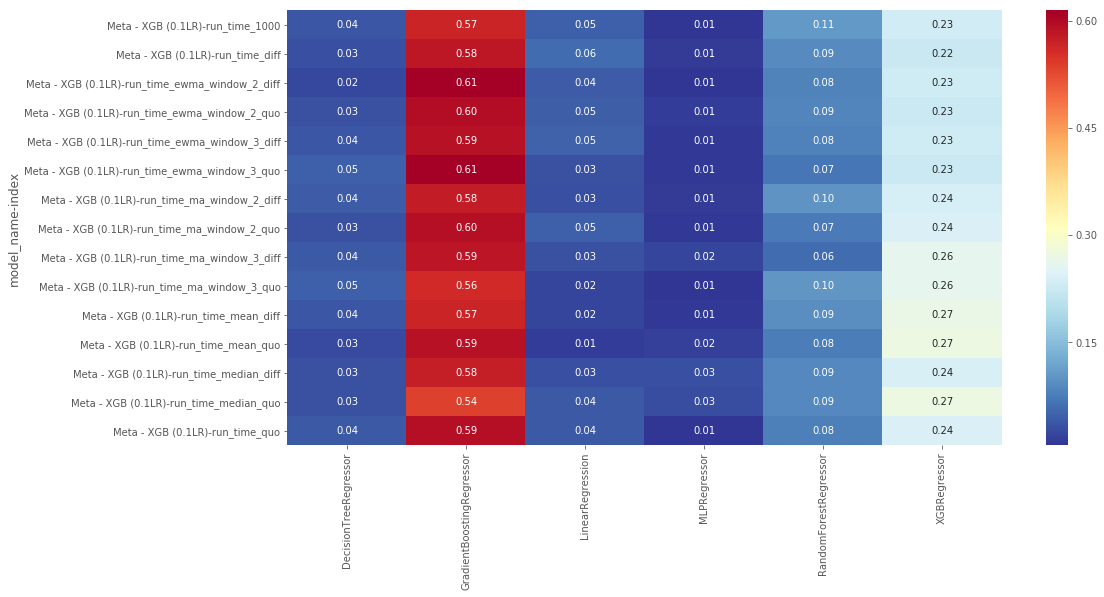

In [6]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report.reset_index().set_index(['model_name', 'index']).astype(float), annot=True, fmt='.2f', cmap='RdYlBu_r')

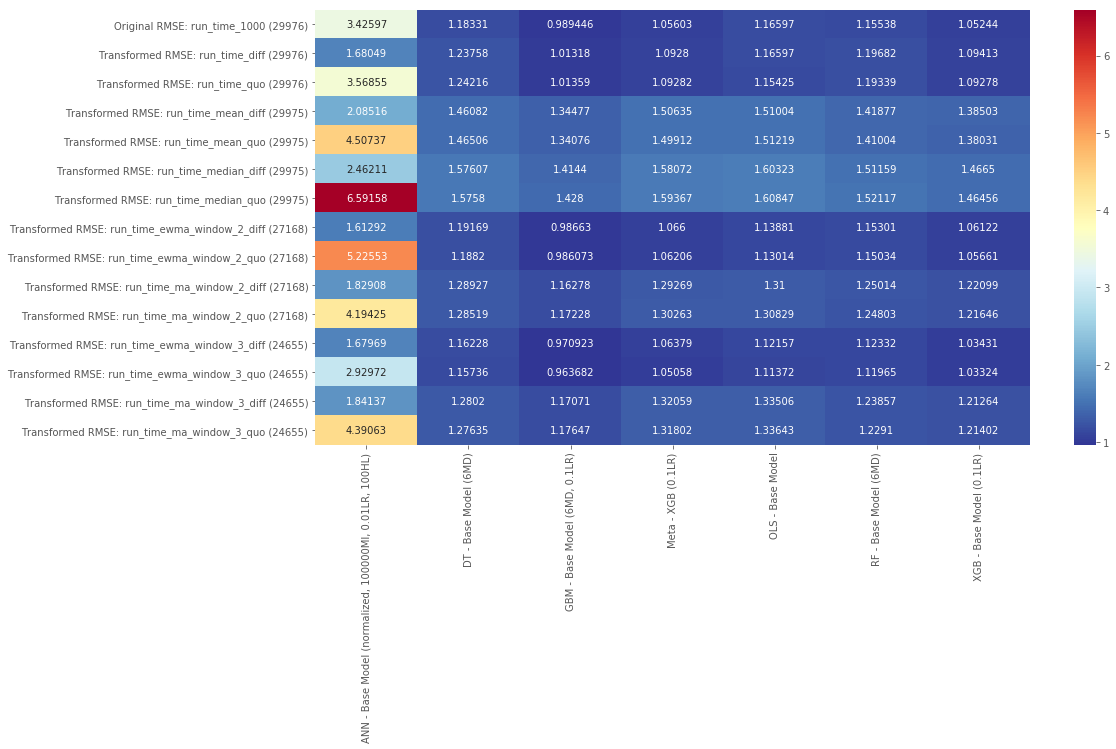

In [7]:
value_df = rmse_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu_r') 

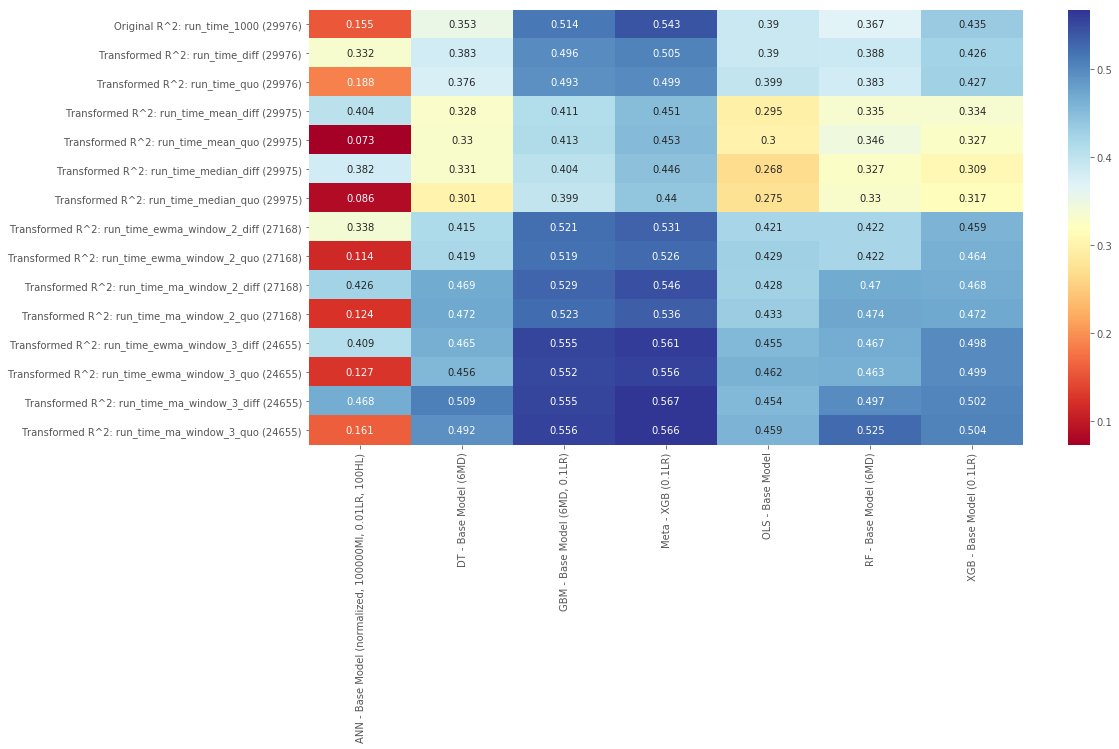

In [8]:
value_df = rsquare_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu')

## 5.3 Grid Search

In [ ]:
def get_best_model(name_saved, model_method, tuned_params, scoring, verbose=2, **params):
    # Get the best model from grid search
    try:
        best_df = pd.read_csv(report_directory + '%s_grid_search_report.csv' % name_saved, index_col=0)
    except FileNotFoundError:
        best_df = start_grid_search(model_method=model_method, tuned_params=tuned_params, 
                                    scoring=scoring, name_to_save=name_saved, verbose=verbose, **params)
    return report_best_params(best_df, scoring=scoring)
        
def report_best_params(df, scoring, col_name='best_params'):
    # Get the best reported parameters
    best_dict = {}
    for column in df.columns:
        if type(df[column]['best_params']) is str:
            best_params = eval(df[column]['best_params'])
        else:
            best_params = df[column]['best_params']
        best_params.update({'score': float(df[column]['best_scores'])})
        best_dict[column] = best_params
    df_return = pd.DataFrame(best_dict).T
    if 'False' in repr(scoring):
        df_return['score'] = -df_return['score']
    return df_return

def start_grid_search(model_method, tuned_params, name_to_save, scoring, verbose=2, cv=5, **params):
    # General method to trigger grid search
    best_dict = {}
    for col_name in mc.y_train.columns:
        grid_search = GridSearchCV(model_method(**params), tuned_params, cv=cv, scoring=scoring, verbose=verbose)
        y = mc.y[col_name].dropna()
        X = mc.X[mc.X.index.isin(y.index)]
        grid_search.fit(np.array(X), np.array(y))
        best_dict[col_name] = {
            'best_estimator': grid_search.best_estimator_, 
            'best_params': grid_search.best_params_, 
            'best_scores': grid_search.best_score_
        }
    best_df = pd.DataFrame(best_dict)
    file_name = '%s_grid_search_report.csv' % name_to_save
    print('Report file saved as %s' % file_name)
    best_df.to_csv(report_directory + file_name)
    return best_df

### 5.3.1 Artificial Nerural Network Hyper-parameter Tuning 

In [ ]:
ann_tuned_params = [
    {'activation': ['relu', 'tanh'], 
     'learning_rate_init': [0.01, ], 
     'max_iter': [100000, ], 
     'hidden_layer_sizes': [(100, ), (150, ), (200, ), (250, ), (300, ), (350, )]}
]
get_best_model('ann', MLPRegressor, ann_tuned_params, scoring=rmse_score, verbose=1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.8min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.5min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.9min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.2min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.5min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.0min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\terry\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.0min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\terry\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\terry\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### 5.3.2 Random Forest Hyper-parameter Tuning

In [ ]:
rf_tuned_params = [
    {'n_estimators': [5, 10, 20, 40], 
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [5, 6]}
]
get_best_model('rf', RandomForestRegressor, rf_tuned_params, scoring=rmse_score, verbose=1)

### 5.3.3 XGBoost Hyper-parameter Tuning

In [ ]:
xgb_tuned_params = [
    {'max_depth': [3, 6, 9],
     'subsample': [0.6, 0.8, 1],
     'min_child_weight': [1, 3, 6, 10]}
]
get_best_model('xgb', XGBRegressor, xgb_tuned_params, scoring=rmse_score, verbose=1)

## 5.4 OLS Stacking Model with Grid Search Cross-Validation

In [ ]:
# Change the condition to enable the statements
if 1 == 1:
    # Stacking model
    ols = LinearRegression(fit_intercept=False)
    xgb = XGBRegressor(learning_rate=0.1)
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    ann = MLPRegressor(max_iter=100000, learning_rate_init=0.01, activation='tanh')
    gbm = GradientBoostingRegressor(learning_rate=0.1)

    stack_tuned_params = {'xgbregressor__max_depth': [6, 9],
                          'xgbregressor__min_child_weight': [3, 10],
                          'xgbregressor__subsample': [0.8, 1],        
                          'randomforestregressor__n_estimators': [20, 40], 
                          'randomforestregressor__max_depth': [5, 6],
                          'mlpregressor__hidden_layer_sizes': [(100, ), (200, ), (250, ), (350, )],
                          'gradientboostingregressor__n_estimators': [50, 100, 200],
                          'gradientboostingregressor__max_features': [20, 30, 'auto'],
                          'gradientboostingregressor__subsample': [0.8, 1]}
    ols_meta = LinearRegression(fit_intercept=True)
    get_best_model('ols_stack', 
                   model_method=StackingCVRegressor, 
                   tuned_params=stack_tuned_params, 
                   scoring=rmse_score, verbose=1,
                   regressors=[ols, xgb, dt, rf, ann, gbm], 
                   meta_regressor=ols_meta, 
                   use_features_in_secondary=True)